# YUV image compression

In [3]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
#plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

import pylab
import math
import numpy as np
from scipy import signal
import cv2
import os
!ln -sf ~/MRVC/src/deadzone.py .
!ln -sf ~/MRVC/src/frame.py .
!ln -sf ~/MRVC/src/YCrCb.py .
!ln -sf ~/MRVC/src/YCoCg.py .
!ln -sf ~/MRVC/src/distortion.py .
!ln -sf ~/MRVC/src/debug.py
!ln -sf ~/MRVC/src/information.py .
!ln -sf ~/MRVC/src/image_3.py
!ln -sf ~/MRVC/src/image_1.py
import deadzone as Q
import YCrCb
import YCoCg
import distortion
import information
import image_3 as RGB_img
import image_1 as gray_img
import colored

ImportError: /home/vruiz/.pyenv/versions/3.10.0/lib/python3.10/site-packages/scipy/spatial/transform/rotation.cpython-310-x86_64-linux-gnu.so: undefined symbol: _PyGen_Send

## Configuration area

In [2]:
# Prefix of the RGB image to be quantized.

home = os.environ["HOME"]
#fn = home + "/MRVC/sequences/stockholm/"
fn = home + "/MRVC/sequences/lena_color/"

# Number of quantization steps.
Q_steps = 8

components = ['R', 'G', 'B']

image_3.read: /home/vruiz/MRVC/sequences/lena_color/000.png (512, 512, 3) uint8 512673 
255 1


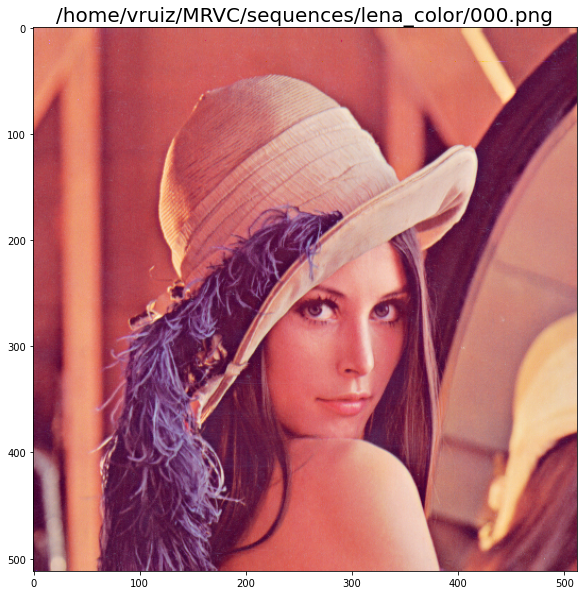

In [3]:
# Read the image and show it.

img = RGB_img.read(fn)
print(img.max(), img.min())

def show(img, title):
    img = RGB_img.normalize(img)
    plt.figure(figsize=(10,10))
    plt.title(title, fontsize=20)
    plt.imshow(img)

show(img, fn + "000.png")

In [4]:
# Dead-zone quantizer & dequantizer.
# 
# Notice that, although this is a dead-zone quantizer, we are not going
# to work with negative samples, and therefore, the dead-zone
# does not have any effect.

def q_deq(x, quantization_step):
    k = Q.quantize(x, quantization_step)
    y = Q.dequantize(k, quantization_step)
    return k, y

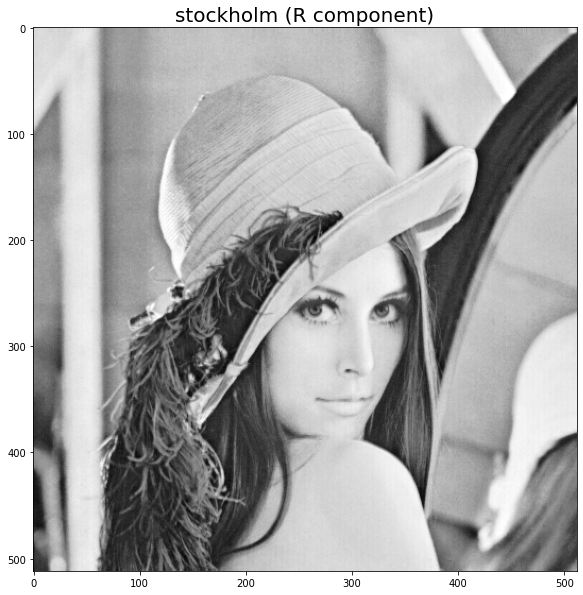

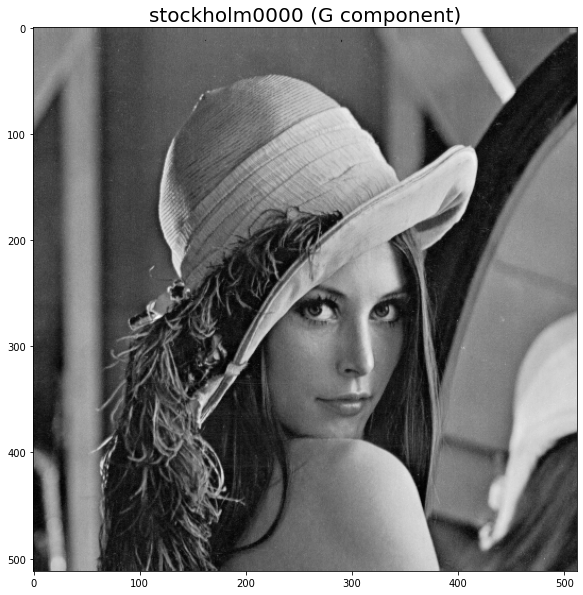

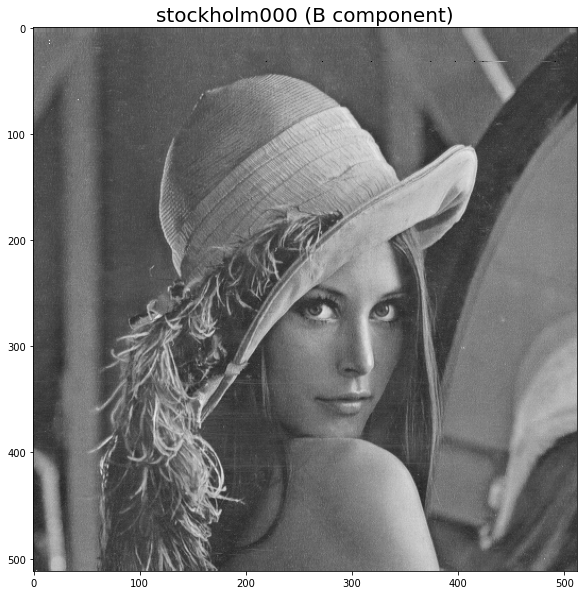

In [5]:
def show_gray(img, title):
    img = gray_img.normalize(img)
    plt.figure(figsize=(10,10))
    plt.title(title, fontsize=20)
    plt.imshow(img, cmap='gray')
show_gray(img[:,:,0], "stockholm (R component)")
show_gray(img[:,:,1], "stockholm0000 (G component)")
show_gray(img[:,:,2], "stockholm000 (B component)")

## YCrCb components

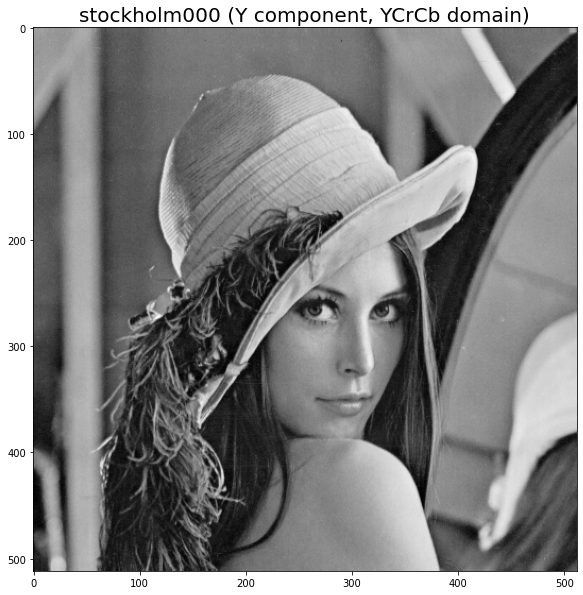

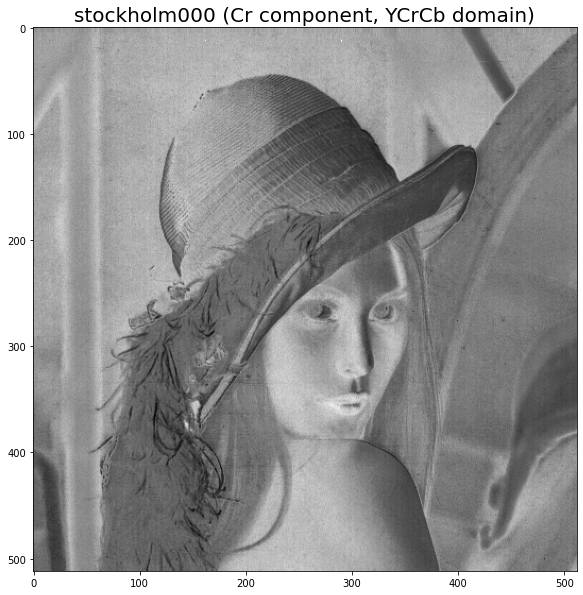

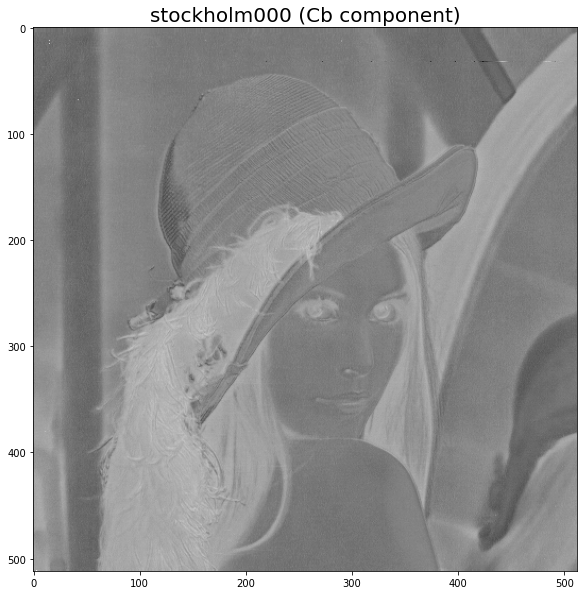

In [6]:
YCrCb_img = YCrCb.from_RGB(img.astype(np.uint8))
show_gray(YCrCb_img[:,:,0], "stockholm000 (Y component, YCrCb domain)")
show_gray(YCrCb_img[:,:,1], "stockholm000 (Cr component, YCrCb domain)")
show_gray(YCrCb_img[:,:,2], "stockholm000 (Cb component)")

### Is the YCrCb reversible?

(512, 512, 3)
False
255 1
245 25 136.53189977010092


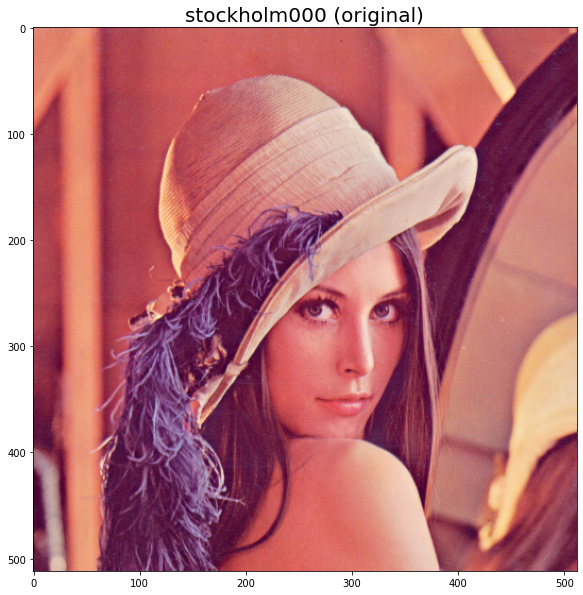

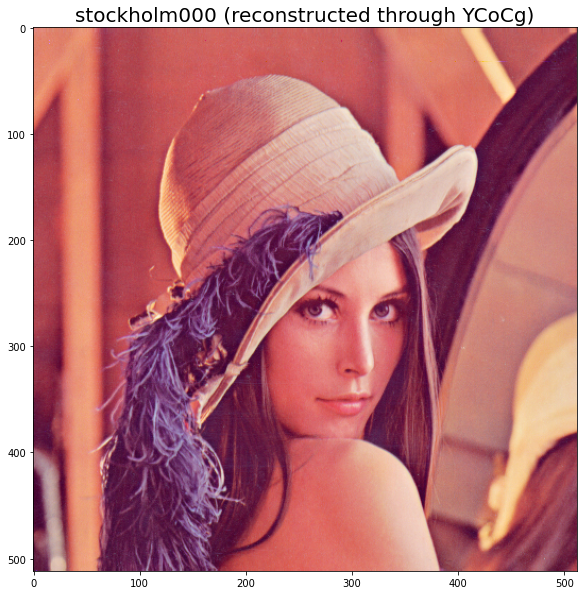

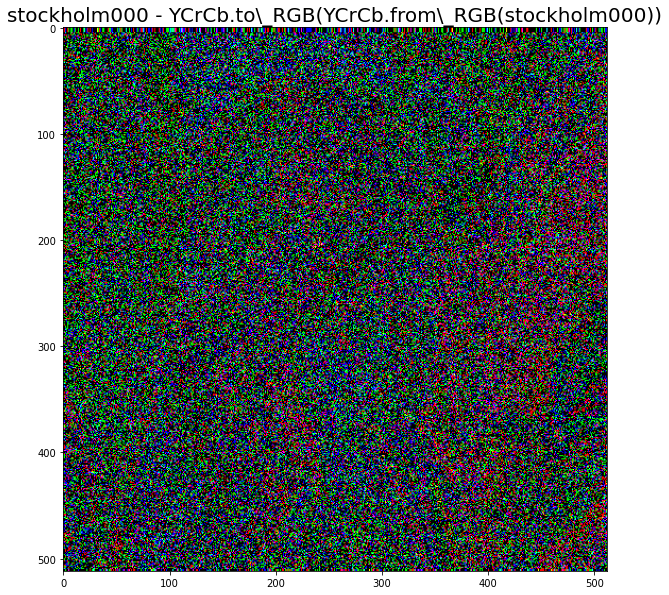

In [7]:
print(YCrCb_img.shape)
img2 = YCrCb.to_RGB(YCrCb_img)
print(np.array_equal(img, img2))
print(img.max(), img.min())
print(YCrCb_img.max(), YCrCb_img.min(), np.average(YCrCb_img))
show(img, "stockholm000 (original)")
show(img2, "stockholm000 (reconstructed through YCoCg)")
show(img-img2, 'stockholm000 - YCrCb.to\_RGB(YCrCb.from\_RGB(stockholm000))')

## YCoCg components

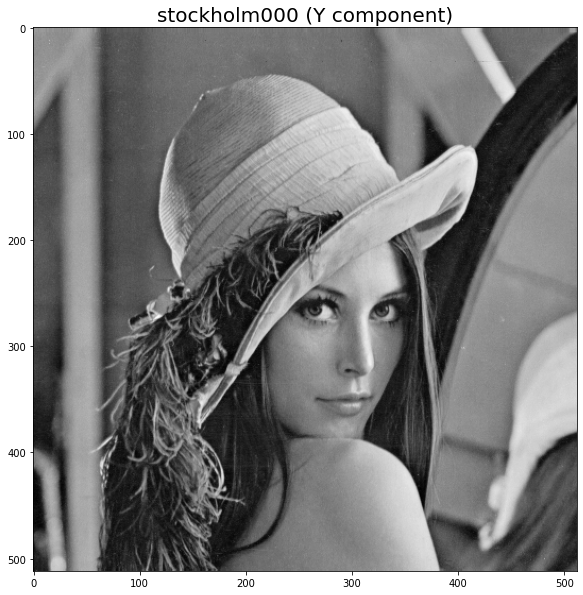

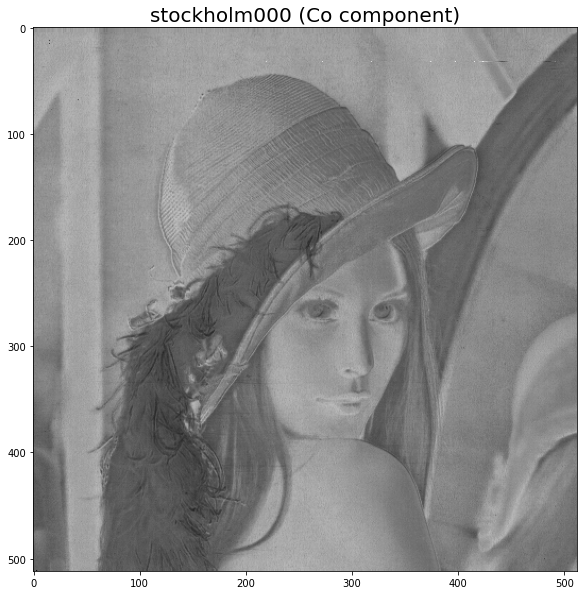

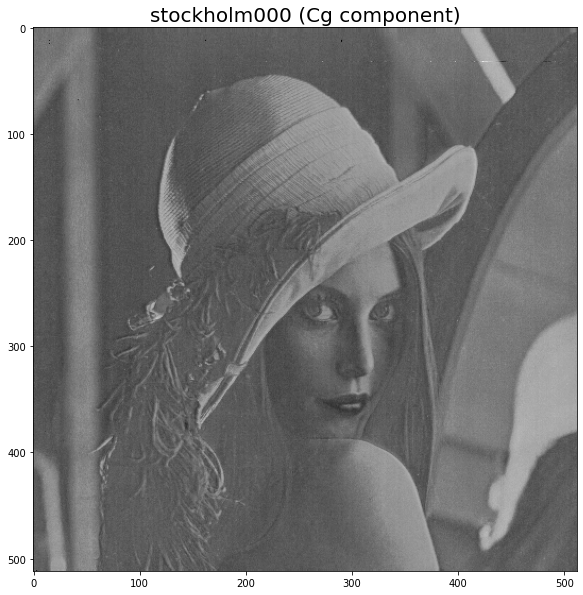

In [8]:
YCoCg_img = YCoCg.from_RGB(img.astype(np.int16))
show_gray(YCoCg_img[:,:,0], "stockholm000 (Y component)")
show_gray(YCoCg_img[:,:,1], "stockholm000 (Co component)")
show_gray(YCoCg_img[:,:,2], "stockholm000 (Cg component)")

### Is the YCoCg reversible?

False
255 1
241 -60 45.39967346191406


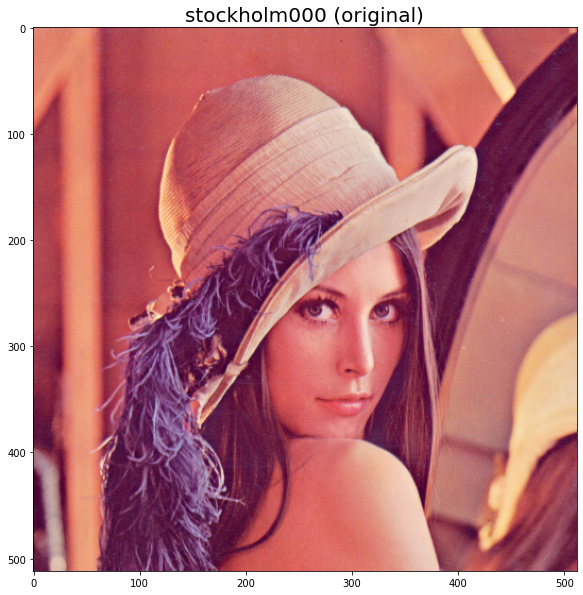

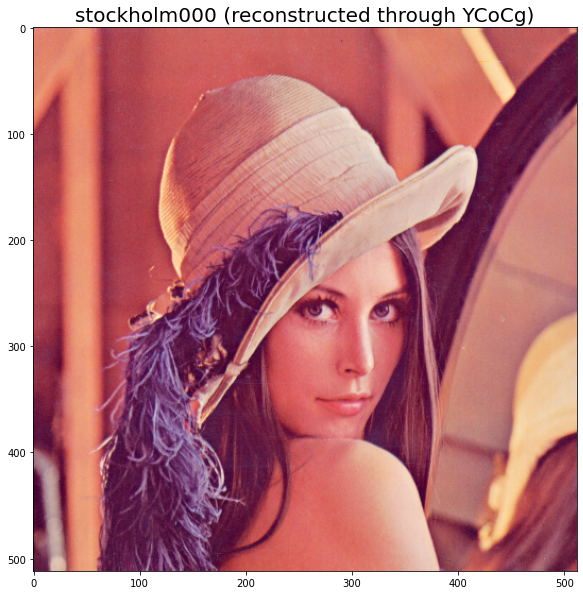

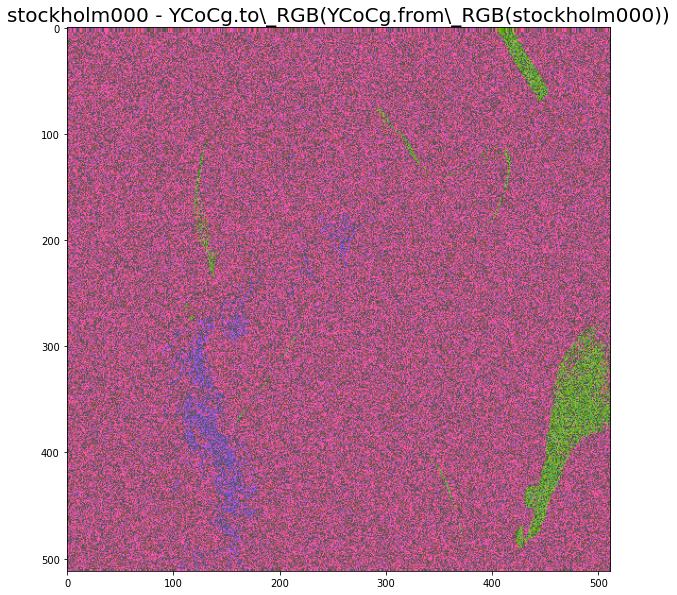

In [9]:
img2 = YCoCg.to_RGB(YCoCg_img)
print(np.array_equal(img, img2))
print(img.max(), img.min())
print(YCoCg_img.max(), YCoCg_img.min(), np.average(YCoCg_img))
show(img, "stockholm000 (original)")
show(img2, "stockholm000 (reconstructed through YCoCg)")
show(img-img2, 'stockholm000 - YCoCg.to\_RGB(YCoCg.from\_RGB(stockholm000))')

## Gains of the YCrCb synthesis filters 

In [10]:
val = 10
delta_YCrCb = np.array([val, 0, 0]).astype(np.uint8).reshape(1,1,3)
delta_RGB = YCrCb.to_RGB(delta_YCrCb)
print("delta_YCrCb =", delta_YCrCb, "delta_RGB =", delta_RGB, "Y gain =", information.average_energy(delta_RGB))

delta_YCrCb = np.array([0, val, 0]).astype(np.uint8).reshape(1,1,3)
delta_RGB = YCrCb.to_RGB(delta_YCrCb)
print("delta_YCrCb =", delta_YCrCb, "delta_RGB =", delta_RGB, "Cr gain =", information.average_energy(delta_RGB))

delta_YCrCb = np.array([0, 0, val]).astype(np.uint8).reshape(1,1,3)
delta_RGB = YCrCb.to_RGB(delta_YCrCb)
print("delta_YCrCb =", delta_YCrCb, "delta_RGB =", delta_RGB, "Cb gain =", information.average_energy(delta_RGB))

delta_YCrCb = np.array([val, val, val]).astype(np.uint8).reshape(1,1,3)
delta_RGB = YCrCb.to_RGB(delta_YCrCb)
print("delta_YCrCb =", delta_YCrCb, "delta_RGB =", delta_RGB, "Total gain =", information.average_energy(delta_RGB))

delta_YCrCb = [[[10  0  0]]] delta_RGB = [[[  0 145   0]]] Y gain = 7008.333333333333
delta_YCrCb = [[[ 0 10  0]]] delta_RGB = [[[  0 128   0]]] Cr gain = 5461.333333333333
delta_YCrCb = [[[ 0  0 10]]] delta_RGB = [[[  0 132   0]]] Cb gain = 5808.0
delta_YCrCb = [[[10 10 10]]] delta_RGB = [[[  0 135   0]]] Total gain = 6075.0


As we can see, the energy of the components in the YCrCb domain is not additive (the same happens with the distortion generated by the quantization).

In [11]:
val = 10
delta_YCoCg = np.array([val, 0, 0]).reshape(1,1,3)
delta_RGB = YCoCg.to_RGB(delta_YCoCg)
print("delta_YCoCg =", delta_YCoCg, "delta_RGB =", delta_RGB, "Y gain =", information.average_energy(delta_RGB))

delta_YCoCg = np.array([0, val, 0]).reshape(1,1,3)
delta_RGB = YCoCg.to_RGB(delta_YCoCg)
print("delta_YCoCg =", delta_YCoCg, "delta_RGB =", delta_RGB, "Cr gain =", information.average_energy(delta_RGB))

delta_YCoCg = np.array([0, 0, val]).reshape(1,1,3)
delta_RGB = YCoCg.to_RGB(delta_YCoCg)
print("delta_YCoCg =", delta_YCoCg, "delta_RGB =", delta_RGB, "Cb gain =", information.average_energy(delta_RGB))

delta_YCoCg = np.array([val, val, val]).reshape(1,1,3)
delta_RGB = YCoCg.to_RGB(delta_YCoCg)
print("delta_YCoCg =", delta_YCoCg, "delta_RGB =", delta_RGB, "Total gain =", information.average_energy(delta_RGB))

delta_YCoCg = [[[10  0  0]]] delta_RGB = [[[10 10 10]]] Y gain = 100.0
delta_YCoCg = [[[ 0 10  0]]] delta_RGB = [[[ 10   0 -10]]] Cr gain = 66.66666666666667
delta_YCoCg = [[[ 0  0 10]]] delta_RGB = [[[-10  10 -10]]] Cb gain = 100.0
delta_YCoCg = [[[10 10 10]]] delta_RGB = [[[ 10  20 -10]]] Total gain = 200.0


With the YCoCg happens the same (the energy of the components is not additive). The gains matches with the theory.

### Energy of the RGB channels

In [12]:
R_energy = information.average_energy(img[:,:,0])
G_energy = information.average_energy(img[:,:,1])
B_energy = information.average_energy(img[:,:,2])
print("Energy of R =", R_energy)
print("Energy of G =", G_energy)
print("Energy of B =", B_energy)

Energy of R = 34886.45802307129
Energy of G = 12608.167423248291
Energy of B = 12271.964656829834


### Energy of the YCrCb channels

In [13]:
YCrCb_frame = YCrCb.from_RGB(img.astype(np.uint8))
Y_energy = information.average_energy(YCrCb_frame[:,:,0])
Cr_energy = information.average_energy(YCrCb_frame[:,:,1])
Cb_energy = information.average_energy(YCrCb_frame[:,:,2])
print("Energy of Y =", Y_energy)
print("Energy of Cr =", Cr_energy)
print("Energy of Cb =", Cb_energy)

Energy of Y = 17678.79228591919
Energy of Cr = 28406.563133239746
Energy of Cb = 13989.699409484863


### Energy of the YCoCg channels

In [14]:
YCoCg_frame = YCoCg.from_RGB(img.astype(np.int16))
Y_energy = information.average_energy(YCoCg_frame[:,:,0])
Co_energy = information.average_energy(YCoCg_frame[:,:,1])
Cg_energy = information.average_energy(YCoCg_frame[:,:,2])
print("Energy of Y =", Y_energy)
print("Energy of Co =", Co_energy)
print("Energy of Cg =", Cg_energy)

Energy of Y = 16577.96739578247
Energy of Co = 1707.0352058410645
Energy of Cg = 546.0150527954102


The energy is more concentrated in the YCoCg domain, more specifically in the Y channel.

## Generation of the optimal RD curve

The optimal RD curve can be generated with:

1. Convert the image from RGB to YUV.
2. The RD curve of each YUV channel is computed, for a number of quantization steps.
3. The OTP (Optimal Truncation Points) are sorted by slopes.

## Some helper functions

In [18]:
# Number of bytes that a img "img" requires in disk.
def bytes_per_RGB_img(img, fn="img"):
    RGB_img.write(img, "/tmp/" + fn)
    length_in_bytes = os.path.getsize("/tmp/" + fn + "000.png")
    return length_in_bytes

# The same value, but in bits/pixel.
def bits_per_RGB_pixel(img, fn="img"):
    return 8*bytes_per_RGB_img(img, fn)/(img.shape[0]*img.shape[1])

# Specific version for grayscale images.
def bytes_per_gray_img(img, fn="img"):
    cv2.imwrite("/tmp/" + fn + "000.png", img)
    length_in_bytes = os.path.getsize("/tmp/" + fn + "000.png")
    print(colored.fore.GREEN + f"bytes_per_gray_img: /tmp/{fn}000.png", img.shape, img.dtype, length_in_bytes, colored.style.RESET)
    return length_in_bytes

# The same value, but in bits/pixel.
def bits_per_gray_pixel(img, fn="img"):
    return 8*bytes_per_gray_img(img, fn)/(img.shape[0]*img.shape[1])

## Build the optimal RD curve

Neither YCrCb nor YCoCg are orthogonal spaces, which means that even considering the channel gains, the contributions of the channels to the quality of the reconstruction are not additive (the channels are not independent). This implies that the search of the optimal QSs cannot be done by simply sorting the slopes of each OTP of each channel, but by searching for each OTP the best combination of QSs, that not necessarily need to be embbeded (i.e., it can not be asserted that the optimal QSs for a quality level Q generated by a combination $[\Delta_Y^Q, \Delta_U^Q, \Delta_V^Q]$ > $[\Delta_Y^{Q+1}, \Delta_U^{Q+1}, \Delta_V^{Q+1}]$, for all the channels). Unfortunately, this fact significantly complicates the optimal bit-rate control through quantization. 

A way to deal with this problem is ignore the orthogonality lack (well, the YCoCg transform is almost orthogonal, and therefore, we are not supposing something terribly wrong). This is that we are going to implement.

## RD curves of each YCrCb channel
Notice that we compute the distortion in the RGB domain because the transform is not orthogonal. The bit-rate is computed using only the corresponding channel. Remember that the quantization indexes images need to be normalized or equalized to be displayed properly.

In [19]:
def Yrb_RD_curve(RGB_img, Q_steps):
    RD_points = []
    for q in range(Q_steps-1, -1, -1):
        YCrCb_img = YCrCb.from_RGB(RGB_img.astype(np.uint8))
        Y_img = YCrCb_img[:,:,0]
        dequantized_Y_img = np.empty_like(Y_img)
        Q_step = 1 << q
        k, dequantized_Y_img = q_deq(Y_img, Q_step)
        rate = bits_per_gray_pixel(k, 'Yrb' + str(Q_step) + '_')
        #_distortion = distortion.MSE(Y_img, dequantized_Y_img)
        YCrCb_img[...,0] = dequantized_Y_img
        dequantized_RGB_img = YCrCb.to_RGB(YCrCb_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)
        RD_points.append((rate, _distortion, 'Yrb', Q_step))
        print(f"q_step={Q_step:>3}, rate={rate:.3f} bits/pixel, distortion={_distortion}")
    return RD_points

def Cr_RD_curve(RGB_img, Q_steps):
    RD_points = []
    for q in range(Q_steps-1, -1, -1):
        YCrCb_img = YCrCb.from_RGB(RGB_img.astype(np.uint8))
        Cr_img = YCrCb_img[:,:,1]
        dequantized_Cr_img = np.empty_like(Cr_img)
        Q_step = 1 << q
        k, dequantized_Cr_img = q_deq(Cr_img, Q_step)
        rate = bits_per_gray_pixel(k, 'Cr' + str(Q_step) + '_')
        #_distortion = distortion.MSE(Cr_img, dequantized_Cr_img)
        YCrCb_img[...,1] = dequantized_Cr_img
        dequantized_RGB_img = YCrCb.to_RGB(YCrCb_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)
        RD_points.append((rate, _distortion, 'Cr', Q_step))
        print(f"q_step={Q_step:>3}, rate={rate:.3f} bits/pixel, distortion={_distortion}")
    return RD_points

def Cb_RD_curve(RGB_img, Q_steps):
    RD_points = []
    for q in range(Q_steps-1, -1, -1):
        YCrCb_img = YCrCb.from_RGB(RGB_img.astype(np.uint8))
        Cb_img = YCrCb_img[:,:,2]
        dequantized_Cb_img = np.empty_like(Cb_img)
        Q_step = 1 << q
        k, dequantized_Cb_img = q_deq(Cb_img, Q_step)
        rate = bits_per_gray_pixel(k, 'Cb' + str(Q_step) + '_')
        #_distortion = distortion.MSE(Cb_img, dequantized_Cb_img)
        YCrCb_img[...,2] = dequantized_Cb_img
        dequantized_RGB_img = YCrCb.to_RGB(YCrCb_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)        
        RD_points.append((rate, _distortion, 'Cb', Q_step))
        print(f"q_step={Q_step:>3}, rate={rate:.3f} bits/pixel, distortion={_distortion}")
    return RD_points

Yrb_points = Yrb_RD_curve(img, Q_steps)
Cr_points = Cr_RD_curve(img, Q_steps)
Cb_points = Cb_RD_curve(img, Q_steps)

bytes_per_gray_img: /tmp/Yrb128_000.png (512, 512) int16 15694 
q_step=128, rate=0.479 bits/pixel, distortion=3733.4162012736
bytes_per_gray_img: /tmp/Yrb64_000.png (512, 512) int16 26305 
q_step= 64, rate=0.803 bits/pixel, distortion=1238.3948885599773
bytes_per_gray_img: /tmp/Yrb32_000.png (512, 512) int16 37845 
q_step= 32, rate=1.155 bits/pixel, distortion=323.94666798909503
bytes_per_gray_img: /tmp/Yrb16_000.png (512, 512) int16 56917 
q_step= 16, rate=1.737 bits/pixel, distortion=77.95892588297527
bytes_per_gray_img: /tmp/Yrb8_000.png (512, 512) int16 78434 
q_step=  8, rate=2.394 bits/pixel, distortion=17.682655334472656
bytes_per_gray_img: /tmp/Yrb4_000.png (512, 512) int16 104734 
q_step=  4, rate=3.196 bits/pixel, distortion=3.8227869669596353
bytes_per_gray_img: /tmp/Yrb2_000.png (512, 512) int16 135055 
q_step=  2, rate=4.122 bits/pixel, distortion=0.858483632405599
bytes_per_gray_img: /tmp/Yrb1_000.png (512, 512) int16 167625 
q_step=  1, rate=5.116 bits/pixel, distortion=

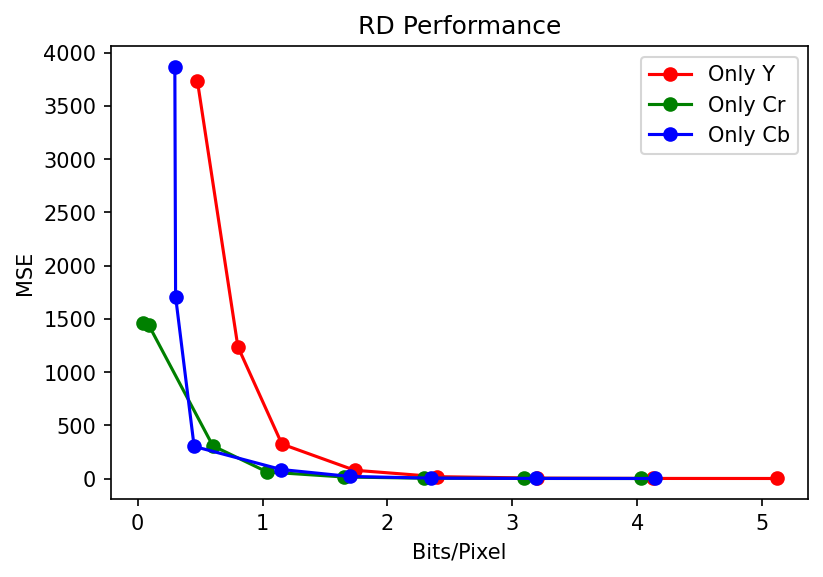

In [20]:
pylab.figure(dpi=150)
#pylab.plot(*zip(*YCrCb_points), c='m', marker="x",
#           label='$\Delta_{\mathrm{Y}} = \Delta_{\mathrm{Cr}} = \Delta_{\mathrm{Cb}}$')
pylab.plot(*zip(*[(i[0], i[1]) for i in Yrb_points]), c='r', marker="o", label='Only Y')              
pylab.plot(*zip(*[(i[0], i[1]) for i in Cr_points]), c='g', marker="o",
           label='Only Cr')              
pylab.plot(*zip(*[(i[0], i[1]) for i in Cb_points]), c='b', marker="o",
           label='Only Cb')              
pylab.title("RD Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

Conclusions:
1. The distortions are not additive.
2. The slopes of the curves for different quantization steps are different.

### RD curves of each YCoCg channel

In [22]:
def Yog_RD_curve(RGB_img, Q_steps):
    RD_points = []
    for q in range(Q_steps-1, -1, -1):
        YCoCg_img = YCoCg.from_RGB(RGB_img.astype(np.int16))
        Y_img = YCoCg_img[:,:,0]
        dequantized_Y_img = np.empty_like(Y_img)
        Q_step = 1 << q
        k, dequantized_Y_img = q_deq(Y_img, Q_step)
        k = k.astype(np.uint8)
        rate = bits_per_gray_pixel(k, 'Yog' + str(Q_step) + '_')
        #_distortion = distortion.MSE(Y_img, dequantized_Y_img)
        YCoCg_img[...,0] = dequantized_Y_img
        dequantized_RGB_img = YCoCg.to_RGB(YCoCg_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)        
        RD_points.append((rate, _distortion, 'Yog', Q_step))
        print(f"Q_step={Q_step:>3}, rate={rate:.3f} bits/pixel, distortion={_distortion}")
    return RD_points

def Co_RD_curve(RGB_img, Q_steps):
    RD_points = []
    for q in range(Q_steps-1, -1, -1):
        YCoCg_img = YCoCg.from_RGB(RGB_img.astype(np.int16))
        Co_img = YCoCg_img[:,:,1]
        dequantized_Co_img = np.empty_like(Co_img)
        Q_step = 1 << q
        k, dequantized_Co_img = q_deq(Co_img, Q_step)
        k = k.astype(np.uint8)
        rate = bits_per_gray_pixel(k, 'Co' + str(Q_step) + '_')
        #_distortion = distortion.MSE(Co_img, dequantized_Co_img)
        YCoCg_img[...,1] = dequantized_Co_img
        dequantized_RGB_img = YCoCg.to_RGB(YCoCg_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)        
        RD_points.append((rate, _distortion, 'Co', Q_step))
        print(f"Q_step={Q_step:>3}, rate={rate:.3f} bits/pixel, distortion={_distortion}")
    return RD_points

def Cg_RD_curve(RGB_img, Q_steps):
    RD_points = []
    for q in range(Q_steps-1, -1, -1):
        YCoCg_img = YCoCg.from_RGB(RGB_img.astype(np.int16))
        Cg_img = YCoCg_img[:,:,2]
        dequantized_Cg_img = np.empty_like(Cg_img)
        Q_step = 1 << q
        k, dequantized_Cg_img = q_deq(Cg_img, Q_step)
        k = k.astype(np.uint8)
        rate = bits_per_gray_pixel(k, 'Cg' + str(Q_step) + '_')
        #_distortion = distortion.MSE(Cg_img, dequantized_Cg_img)
        YCoCg_img[...,2] = dequantized_Cg_img
        dequantized_RGB_img = YCoCg.to_RGB(YCoCg_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)        
        RD_points.append((rate, _distortion, 'Cg', Q_step))
        print(f"Q_step={Q_step:>3}, rate={rate:.3f} bits/pixel, distortion={_distortion}")
    return RD_points

Yog_points = Yog_RD_curve(img, Q_steps)
Co_points = Co_RD_curve(img, Q_steps)
Cg_points = Cg_RD_curve(img, Q_steps)

bytes_per_gray_img: /tmp/Yog128_000.png (512, 512) uint8 15496 
Q_step=128, rate=0.473 bits/pixel, distortion=5128.993265787761
bytes_per_gray_img: /tmp/Yog64_000.png (512, 512) uint8 25970 
Q_step= 64, rate=0.793 bits/pixel, distortion=1410.5414428710938
bytes_per_gray_img: /tmp/Yog32_000.png (512, 512) uint8 37277 
Q_step= 32, rate=1.138 bits/pixel, distortion=349.77915445963544
bytes_per_gray_img: /tmp/Yog16_000.png (512, 512) uint8 55470 
Q_step= 16, rate=1.693 bits/pixel, distortion=85.58140055338542
bytes_per_gray_img: /tmp/Yog8_000.png (512, 512) uint8 78607 
Q_step=  8, rate=2.399 bits/pixel, distortion=21.639506022135418
bytes_per_gray_img: /tmp/Yog4_000.png (512, 512) uint8 104797 
Q_step=  4, rate=3.198 bits/pixel, distortion=5.621480305989583
bytes_per_gray_img: /tmp/Yog2_000.png (512, 512) uint8 135150 
Q_step=  2, rate=4.124 bits/pixel, distortion=1.6519775390625
bytes_per_gray_img: /tmp/Yog1_000.png (512, 512) uint8 167746 
Q_step=  1, rate=5.119 bits/pixel, distortion=0

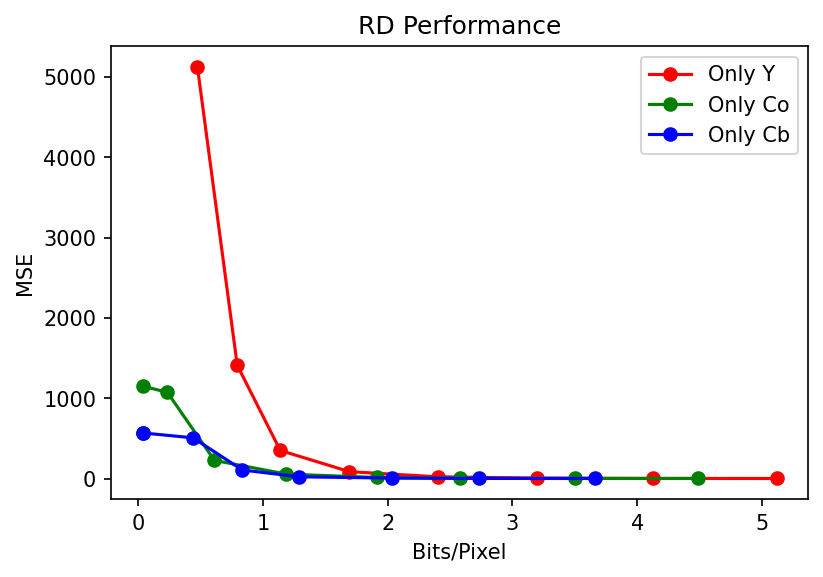

In [23]:
pylab.figure(dpi=150)
#pylab.plot(*zip(*YCoCg_points), c='m', marker="x",
#           label='$\Delta_{\mathrm{Y}} = \Delta_{\mathrm{Co}} = \Delta_{\mathrm{Cg}}$')
pylab.plot(*zip(*[(i[0], i[1]) for i in Yog_points]), c='r', marker="o", label='Only Y')              
pylab.plot(*zip(*[(i[0], i[1]) for i in Co_points]), c='g', marker="o",
           label='Only Co')              
pylab.plot(*zip(*[(i[0], i[1]) for i in Cg_points]), c='b', marker="o",
           label='Only Cb')              
pylab.title("RD Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

Conclusions:
1. The distortions are not additive.
2. The slopes of the curves for different quantization steps are different.
3. The channel Y should be quantized less.

## Compute the slopes
In a different list for each component.

In [24]:
def compute_slopes(RD_points):
    extended_RD_points = [(0.0, 0.0, '', -1)] + RD_points
    counter = 0
    RD_slopes = [(9.0E9, RD_points[0])]
    points_iterator = iter(RD_points)
    next(points_iterator)
    for i in points_iterator:
        BPP = i[0] # Rate 
        delta_BPP = BPP - RD_points[counter][0]
        MSE = i[1] # Distortion
        delta_MSE = MSE - RD_points[counter][1] 
        if delta_BPP > 0:
            slope = abs(delta_MSE/delta_BPP)
        else:
            slope = 0
        component = i[2]
        q_step = i[3]
        print((slope, i), delta_MSE, delta_BPP)
        RD_slopes.append((slope, i))
        counter += 1
    return RD_slopes

Yrb_slopes = compute_slopes(Yrb_points)
Cr_slopes = compute_slopes(Cr_points)
Cb_slopes = compute_slopes(Cb_points)

Yog_slopes = compute_slopes(Yog_points)
Co_slopes = compute_slopes(Co_points)
Cg_slopes = compute_slopes(Cg_points)

(7704.915500424088, (0.802764892578125, 1238.3948885599773, 'Yrb', 64)) -2495.021312713623 0.323822021484375
(2596.589193385327, (1.154937744140625, 323.94666798909503, 'Yrb', 32)) -914.4482205708823 0.3521728515625
(422.6366575782997, (1.736968994140625, 77.95892588297527, 'Yrb', 16)) -245.98774210611975 0.58203125
(91.79406205945688, (2.39361572265625, 17.682655334472656, 'Yrb', 8)) -60.27627054850261 0.656646728515625
(17.2684474017744, (3.19622802734375, 3.8227869669596353, 'Yrb', 4)) -13.859868367513021 0.8026123046875
(3.2035319305651746, (4.121551513671875, 0.858483632405599, 'Yrb', 2)) -2.964303334554036 0.925323486328125
(0.4824953945348481, (5.115509033203125, 0.37890370686848956, 'Yrb', 1)) -0.47957992553710943 0.99395751953125
(398.1814208518754, (0.088226318359375, 1444.0906257629395, 'Cr', 64)) -19.114360809326172 0.048004150390625
(2211.030502155769, (0.602569580078125, 306.8619855244954, 'Cr', 32)) -1137.228640238444 0.51434326171875
(564.563634125756, (1.03646850585937

## Merge the RD slopes and sort them
By slope.

In [25]:
all_YCrCb_slopes = Yrb_slopes + Cr_slopes + Cb_slopes
sorted_YCrCb_slopes = sorted(all_YCrCb_slopes, key=lambda x: x[0])[::-1]

all_YCoCg_slopes = Yog_slopes + Co_slopes + Cg_slopes
sorted_YCoCg_slopes = sorted(all_YCoCg_slopes, key=lambda x: x[0])[::-1]

## Build the sub-optimal RD curve

Progressively quantize the image using the Q_steps described in the sorted list of monotonously decreasing slopes, and then, compute the distortion and the bit-rate. Remember that the quantization indexes images must be normalized or equalized to be displayed properly, and also, that they are in the YUV domain.

In [42]:
# Falta hacer la transformada!!

def YCrCb_get_suboptimal_RD_curve(RGB_img, sorted_slopes, components):
    points = []
    Q_steps_per_component = [256, 256, 256] # This should generate a black image.
    k = np.empty_like(RGB_img)
    y = np.empty_like(RGB_img)
    YCrCb_img = YCrCb.from_RGB(RGB_img.astype(np.uint8))
    for i in sorted_slopes:
        point = i[1]
        component = point[2]
        Q_step = point[3]
        Q_steps_per_component[components.index(component)] = Q_step
        #print(i, Q_steps_per_component)
        for c,Q_step in zip(components, Q_steps_per_component):
            k[..., components.index(c)], y[..., components.index(c)] = q_deq(YCrCb_img[..., components.index(c)], Q_step)
        k = k.astype(np.uint8)
        rate = bits_per_RGB_pixel(k, str(Q_steps_per_component) + '_')
        #_distortion = distortion.MSE(YCrCb_img, y)
        #YCoCg_img[...,2] = dequantized_Cg_img
        dequantized_RGB_img = YCrCb.to_RGB(y)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)        
        points.append((rate, _distortion))
        print(f"Q_step={Q_steps_per_component}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

def YCoCg_get_suboptimal_RD_curve(RGB_img, sorted_slopes, components):
    points = []
    Q_steps_per_component = [256, 256, 256] # This should generate a black image.
    k = np.empty_like(RGB_img)
    y = np.empty_like(RGB_img)
    YCrCb_img = YCoCg.from_RGB(RGB_img.astype(np.int16))
    for i in sorted_slopes:
        point = i[1]
        component = point[2]
        Q_step = point[3]
        Q_steps_per_component[components.index(component)] = Q_step
        #print(i, Q_steps_per_component)
        for c,Q_step in zip(components, Q_steps_per_component):
            k[..., components.index(c)], y[..., components.index(c)] = q_deq(YCrCb_img[..., components.index(c)], Q_step)
        k = k.astype(np.uint8)
        rate = bits_per_RGB_pixel(k, str(Q_steps_per_component) + '_')
        #_distortion = distortion.MSE(YCrCb_img, y)
        #YCoCg_img[...,2] = dequantized_Cg_img
        dequantized_RGB_img = YCoCg.to_RGB(y)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)        
        points.append((rate, _distortion))
        print(f"Q_step={Q_steps_per_component}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

YCrCb_suboptimal_points = YCrCb_get_suboptimal_RD_curve(img, sorted_YCrCb_slopes, ['Yrb', 'Cr', 'Cb'])
YCoCg_suboptimal_points = YCoCg_get_suboptimal_RD_curve(img, sorted_YCoCg_slopes, ['Yog', 'Co', 'Cg'])

image_3.write: /tmp/[256, 256, 128]_000.png (512, 512, 3) uint8 13377 
Q_step=[256, 256, 128], rate=0.408233642578125 bits/pixel, distortion=16567.5
image_3.write: /tmp/[256, 128, 128]_000.png (512, 512, 3) uint8 13681 
Q_step=[256, 128, 128], rate=0.417510986328125 bits/pixel, distortion=17790.3
image_3.write: /tmp/[128, 128, 128]_000.png (512, 512, 3) uint8 30148 
Q_step=[128, 128, 128], rate=0.9200439453125 bits/pixel, distortion=9484.5
image_3.write: /tmp/[128, 128, 64]_000.png (512, 512, 3) uint8 30392 
Q_step=[128, 128, 64], rate=0.927490234375 bits/pixel, distortion=8889.7
image_3.write: /tmp/[128, 128, 32]_000.png (512, 512, 3) uint8 37669 
Q_step=[128, 128, 32], rate=1.149566650390625 bits/pixel, distortion=7481.7
image_3.write: /tmp/[64, 128, 32]_000.png (512, 512, 3) uint8 51514 
Q_step=[64, 128, 32], rate=1.57208251953125 bits/pixel, distortion=4206.8
image_3.write: /tmp/[32, 128, 32]_000.png (512, 512, 3) uint8 69762 
Q_step=[32, 128, 32], rate=2.12896728515625 bits/pixel,

## Optimal quantization in the RGB domain
See [RGB_quantization.ipynb](file:///home/vruiz/Sistemas-Multimedia.github.io/milestones/05-RGB_quantization/RGB_quantization.ipynb).

In [33]:
RGB_points = []
with open('../05-RGB_quantization/RGB.txt', 'r') as f:
    #rate, _distortion = f.read()
    #RGB_points.append((rate, _distortion))
    for line in f:
        rate, _distortion = line.split('\t')
        RGB_points.append((float(rate), float(_distortion)))

## RD curve using same $\Delta$ for each YUV channel ($\Delta_{\text{Y}} = \Delta_{\text{U}} = \Delta_{\text{V}}$)

In [36]:
def YCrCb_RD_curve_same_delta(RGB_img):
    RD_points = []
    for q in range(0, 8):
        YCrCb_img = YCrCb.from_RGB(RGB_img.astype(np.uint8))
        #YCrCb_img = YCrCb_img.astype(np.int16)
        k, dequantized_YCrCb_img = q_deq(YCrCb_img, 1<<q)
        k = k.astype(np.uint8)
        #show(dequantized_YCrCb_img, q_step)
        rate = bits_per_RGB_pixel(k, "YCrCb" + str(1<<q) + "_")
        dequantized_RGB_img = YCrCb.to_RGB(dequantized_YCrCb_img.astype(np.uint8))
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)
        RD_points.append((rate, _distortion))
        print(f"Q_step={1<<q:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return RD_points

YCrCb_points_same_delta = YCrCb_RD_curve_same_delta(img)

image_3.write: /tmp/YCrCb1_000.png (512, 512, 3) uint8 443026 
Q_step=  1, rate=13.52008056640625 bits/pixel, distortion=   0.4
image_3.write: /tmp/YCrCb2_000.png (512, 512, 3) uint8 348188 
Q_step=  2, rate=10.6258544921875 bits/pixel, distortion=   2.1
image_3.write: /tmp/YCrCb4_000.png (512, 512, 3) uint8 261239 
Q_step=  4, rate=7.972381591796875 bits/pixel, distortion=  13.7
image_3.write: /tmp/YCrCb8_000.png (512, 512, 3) uint8 196373 
Q_step=  8, rate=5.992828369140625 bits/pixel, distortion=  69.9
image_3.write: /tmp/YCrCb16_000.png (512, 512, 3) uint8 142703 
Q_step= 16, rate=4.354949951171875 bits/pixel, distortion= 312.6
image_3.write: /tmp/YCrCb32_000.png (512, 512, 3) uint8 85355 
Q_step= 32, rate=2.604827880859375 bits/pixel, distortion=1303.8
image_3.write: /tmp/YCrCb64_000.png (512, 512, 3) uint8 46058 
Q_step= 64, rate=1.40557861328125 bits/pixel, distortion=5652.0
image_3.write: /tmp/YCrCb128_000.png (512, 512, 3) uint8 30148 
Q_step=128, rate=0.9200439453125 bits/pix

In [37]:
with open('YCrCb.txt', 'w') as f:
    for item in YCrCb_points_same_delta:
        f.write(f"{item[0]}\t{item[1]}\n")

In [39]:
def YCoCg_RD_curve_same_delta(RGB_frame):
    RD_points = []
    for q in range(0, 8):
        YCoCg_frame = YCoCg.from_RGB(RGB_frame.astype(np.int16))
        k, dequantized_YCoCg_frame = q_deq(YCoCg_frame, 1<<q)
        k = k.astype(np.uint8)
        rate = bits_per_RGB_pixel(k, "YCoCg" + str(1<<q) + "_")
        dequantized_RGB_frame = YCoCg.to_RGB(dequantized_YCoCg_frame.astype(np.int16))
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
        print(f"Q_step={1<<q:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return RD_points

YCoCg_points_same_delta = YCoCg_RD_curve_same_delta(img)

image_3.write: /tmp/YCoCg1_000.png (512, 512, 3) uint8 445153 
Q_step=  1, rate=13.584991455078125 bits/pixel, distortion=   0.7
image_3.write: /tmp/YCoCg2_000.png (512, 512, 3) uint8 350357 
Q_step=  2, rate=10.692047119140625 bits/pixel, distortion=   3.3
image_3.write: /tmp/YCoCg4_000.png (512, 512, 3) uint8 263086 
Q_step=  4, rate=8.02874755859375 bits/pixel, distortion=  14.8
image_3.write: /tmp/YCoCg8_000.png (512, 512, 3) uint8 195613 
Q_step=  8, rate=5.969635009765625 bits/pixel, distortion=  63.1
image_3.write: /tmp/YCoCg16_000.png (512, 512, 3) uint8 137080 
Q_step= 16, rate=4.183349609375 bits/pixel, distortion= 289.2
image_3.write: /tmp/YCoCg32_000.png (512, 512, 3) uint8 84798 
Q_step= 32, rate=2.58782958984375 bits/pixel, distortion=1292.5
image_3.write: /tmp/YCoCg64_000.png (512, 512, 3) uint8 45117 
Q_step= 64, rate=1.376861572265625 bits/pixel, distortion=3532.6
image_3.write: /tmp/YCoCg128_000.png (512, 512, 3) uint8 20791 
Q_step=128, rate=0.634490966796875 bits/pi

In [40]:
with open('YCoCg.txt', 'w') as f:
    for item in YCoCg_points_same_delta:
        f.write(f"{item[0]}\t{item[1]}\n")

## Let's compare!

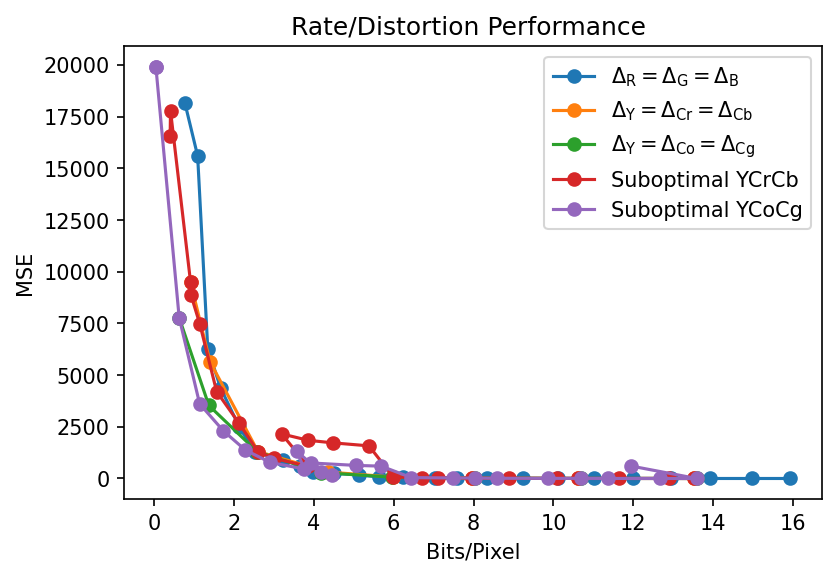

In [44]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RGB_points), marker="o", label="$\Delta_{\mathrm{R}}=\Delta_{\mathrm{G}}=\Delta_{\mathrm{B}}}$")
pylab.plot(*zip(*YCrCb_points_same_delta), marker="o", label="$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}}$")
pylab.plot(*zip(*YCoCg_points_same_delta), marker="o", label="$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}}$")
pylab.plot(*zip(*YCrCb_suboptimal_points), marker="o", label="Suboptimal YCrCb")
pylab.plot(*zip(*YCoCg_suboptimal_points), marker="o", label="Suboptimal YCoCg")
pylab.title("Rate/Distortion Performance ")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
pylab.legend(loc='upper right')
pylab.show()

## Conclusions:
1. In general, quantization is more effective in the transformed domain.
2. At low bit-rates, it's better to quantize in YCoCb domain than to quantize in the YCrCb one. 

### RD using channel gains in YCoCg domain

In [54]:
def YCoCg_RD_curve(RGB_img):
    RD_points = []
    #for q_step in range(0, 8):
    for Q_step in range(1, 256):
        YCoCg_img = YCoCg.from_RGB(RGB_img.astype(np.int16))
        #k, dequantized_YCoCg_img = q_deq(YCoCg_img, 1<<q_step)
        k, dequantized_YCoCg_img = q_deq(YCoCg_img, Q_step)
        k = k.astype(np.uint8)
        rate = bits_per_RGB_pixel(k)
        dequantized_RGB_img = YCoCg.to_RGB(dequantized_YCoCg_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)
        RD_points.append((rate, _distortion))
        print(f"Q_step={Q_step:>3}, rate={rate:>7} BPS, distortion={_distortion:>6.1f}")
    return RD_points

YCoCg_points = YCoCg_RD_curve(img)

relative_Y_gain = 3/2
relative_Co_gain = 1
relative_Cg_gain = 3/2
def YCoCg_RD_curve_with_gains(RGB_img):
    RD_points = []
    #for q_step in range(0, 8):
    for Q_step in range(1, 256):
        YCoCg_img = YCoCg.from_RGB(RGB_img.astype(np.int16))
        dequantized_YCoCg_img = np.empty_like(YCoCg_img)
        k = np.empty_like(YCoCg_img, dtype=np.uint8)
        k[:,:,0], dequantized_YCoCg_img[:,:,0] = q_deq(YCoCg_img[:,:,0], (Q_step)/relative_Y_gain)
        k[:,:,1], dequantized_YCoCg_img[:,:,1] = q_deq(YCoCg_img[:,:,1], (Q_step)/relative_Co_gain)
        k[:,:,2], dequantized_YCoCg_img[:,:,2] = q_deq(YCoCg_img[:,:,2], (Q_step)/relative_Cg_gain)
        #k[0], dequantized_YCoCg_img[0] = q_deq(YCoCg_img[0], q_step/relative_Y_gain)
        #k[1], dequantized_YCoCg_img[1] = q_deq(YCoCg_img[1], q_step/relative_Co_gain)
        #k[2], dequantized_YCoCg_img[2] = q_deq(YCoCg_img[2], q_step/relative_Cg_gain)
        rate = bits_per_RGB_pixel(k)
        dequantized_RGB_img = YCoCg.to_RGB(dequantized_YCoCg_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)
        RD_points.append((rate, _distortion))
        print(f"Q_step={Q_step:>3}, rate={rate:>7} BPS, distortion={_distortion:>6.1f}")
    return RD_points

YCoCg_gains_points = YCoCg_RD_curve_with_gains(img)

image_3.write: /tmp/img000.png (512, 512, 3) uint8 445153 
Q_step=  1, rate=13.584991455078125 BPS, distortion=   0.7
image_3.write: /tmp/img000.png (512, 512, 3) uint8 350357 
Q_step=  2, rate=10.692047119140625 BPS, distortion=   3.3
image_3.write: /tmp/img000.png (512, 512, 3) uint8 297067 
Q_step=  3, rate=9.065765380859375 BPS, distortion=   8.0
image_3.write: /tmp/img000.png (512, 512, 3) uint8 263086 
Q_step=  4, rate=8.02874755859375 BPS, distortion=  14.8
image_3.write: /tmp/img000.png (512, 512, 3) uint8 241192 
Q_step=  5, rate=7.360595703125 BPS, distortion=  23.7
image_3.write: /tmp/img000.png (512, 512, 3) uint8 223893 
Q_step=  6, rate=6.832672119140625 BPS, distortion=  34.9
image_3.write: /tmp/img000.png (512, 512, 3) uint8 209920 
Q_step=  7, rate=6.40625 BPS, distortion=  47.2
image_3.write: /tmp/img000.png (512, 512, 3) uint8 195613 
Q_step=  8, rate=5.969635009765625 BPS, distortion=  63.1
image_3.write: /tmp/img000.png (512, 512, 3) uint8 185596 
Q_step=  9, rate=

image_3.write: /tmp/img000.png (512, 512, 3) uint8 35154 
Q_step= 70, rate=1.07281494140625 BPS, distortion=4069.4
image_3.write: /tmp/img000.png (512, 512, 3) uint8 33854 
Q_step= 71, rate=1.03314208984375 BPS, distortion=4136.3
image_3.write: /tmp/img000.png (512, 512, 3) uint8 33559 
Q_step= 72, rate=1.024139404296875 BPS, distortion=4195.4
image_3.write: /tmp/img000.png (512, 512, 3) uint8 33407 
Q_step= 73, rate=1.019500732421875 BPS, distortion=4261.5
image_3.write: /tmp/img000.png (512, 512, 3) uint8 33101 
Q_step= 74, rate=1.010162353515625 BPS, distortion=4338.3
image_3.write: /tmp/img000.png (512, 512, 3) uint8 32571 
Q_step= 75, rate=0.993988037109375 BPS, distortion=4415.6
image_3.write: /tmp/img000.png (512, 512, 3) uint8 31690 
Q_step= 76, rate=0.96710205078125 BPS, distortion=4487.2
image_3.write: /tmp/img000.png (512, 512, 3) uint8 30627 
Q_step= 77, rate=0.934661865234375 BPS, distortion=4551.9
image_3.write: /tmp/img000.png (512, 512, 3) uint8 29693 
Q_step= 78, rate=

image_3.write: /tmp/img000.png (512, 512, 3) uint8 19580 
Q_step=144, rate=0.5975341796875 BPS, distortion=10216.1
image_3.write: /tmp/img000.png (512, 512, 3) uint8 19568 
Q_step=145, rate=0.59716796875 BPS, distortion=10421.3
image_3.write: /tmp/img000.png (512, 512, 3) uint8 19682 
Q_step=146, rate=0.60064697265625 BPS, distortion=10624.4
image_3.write: /tmp/img000.png (512, 512, 3) uint8 19658 
Q_step=147, rate=0.59991455078125 BPS, distortion=10848.6
image_3.write: /tmp/img000.png (512, 512, 3) uint8 19470 
Q_step=148, rate=0.59417724609375 BPS, distortion=11073.1
image_3.write: /tmp/img000.png (512, 512, 3) uint8 19188 
Q_step=149, rate=0.5855712890625 BPS, distortion=11295.6
image_3.write: /tmp/img000.png (512, 512, 3) uint8 18940 
Q_step=150, rate=0.5780029296875 BPS, distortion=11543.9
image_3.write: /tmp/img000.png (512, 512, 3) uint8 18480 
Q_step=151, rate=0.56396484375 BPS, distortion=11777.0
image_3.write: /tmp/img000.png (512, 512, 3) uint8 17944 
Q_step=152, rate=0.5476

image_3.write: /tmp/img000.png (512, 512, 3) uint8 2309 
Q_step=220, rate=0.070465087890625 BPS, distortion=19851.6
image_3.write: /tmp/img000.png (512, 512, 3) uint8 2170 
Q_step=221, rate=0.06622314453125 BPS, distortion=19870.7
image_3.write: /tmp/img000.png (512, 512, 3) uint8 2100 
Q_step=222, rate=0.0640869140625 BPS, distortion=19880.6
image_3.write: /tmp/img000.png (512, 512, 3) uint8 2026 
Q_step=223, rate=0.06182861328125 BPS, distortion=19892.1
image_3.write: /tmp/img000.png (512, 512, 3) uint8 1940 
Q_step=224, rate=0.0592041015625 BPS, distortion=19900.8
image_3.write: /tmp/img000.png (512, 512, 3) uint8 1867 
Q_step=225, rate=0.056976318359375 BPS, distortion=19907.0
image_3.write: /tmp/img000.png (512, 512, 3) uint8 1830 
Q_step=226, rate=0.05584716796875 BPS, distortion=19911.4
image_3.write: /tmp/img000.png (512, 512, 3) uint8 1790 
Q_step=227, rate=0.05462646484375 BPS, distortion=19914.6
image_3.write: /tmp/img000.png (512, 512, 3) uint8 1754 
Q_step=228, rate=0.0535

image_3.write: /tmp/img000.png (512, 512, 3) uint8 112196 
Q_step= 29, rate=3.4239501953125 BPS, distortion= 493.2
image_3.write: /tmp/img000.png (512, 512, 3) uint8 107997 
Q_step= 30, rate=3.295806884765625 BPS, distortion= 487.8
image_3.write: /tmp/img000.png (512, 512, 3) uint8 103472 
Q_step= 31, rate=3.15771484375 BPS, distortion= 543.9
image_3.write: /tmp/img000.png (512, 512, 3) uint8 97769 
Q_step= 32, rate=2.983673095703125 BPS, distortion= 565.9
image_3.write: /tmp/img000.png (512, 512, 3) uint8 93948 
Q_step= 33, rate=2.8670654296875 BPS, distortion= 548.8
image_3.write: /tmp/img000.png (512, 512, 3) uint8 94730 
Q_step= 34, rate=2.89093017578125 BPS, distortion= 593.2
image_3.write: /tmp/img000.png (512, 512, 3) uint8 96533 
Q_step= 35, rate=2.945953369140625 BPS, distortion= 617.0
image_3.write: /tmp/img000.png (512, 512, 3) uint8 98410 
Q_step= 36, rate=3.00323486328125 BPS, distortion= 605.0
image_3.write: /tmp/img000.png (512, 512, 3) uint8 102978 
Q_step= 37, rate=3.1

image_3.write: /tmp/img000.png (512, 512, 3) uint8 37170 
Q_step=100, rate=1.13433837890625 BPS, distortion=3864.0
image_3.write: /tmp/img000.png (512, 512, 3) uint8 36996 
Q_step=101, rate=1.1290283203125 BPS, distortion=3909.4
image_3.write: /tmp/img000.png (512, 512, 3) uint8 36642 
Q_step=102, rate=1.11822509765625 BPS, distortion=3910.4
image_3.write: /tmp/img000.png (512, 512, 3) uint8 36102 
Q_step=103, rate=1.10174560546875 BPS, distortion=4049.4
image_3.write: /tmp/img000.png (512, 512, 3) uint8 35326 
Q_step=104, rate=1.07806396484375 BPS, distortion=4086.5
image_3.write: /tmp/img000.png (512, 512, 3) uint8 34522 
Q_step=105, rate=1.05352783203125 BPS, distortion=4074.9
image_3.write: /tmp/img000.png (512, 512, 3) uint8 33660 
Q_step=106, rate=1.0272216796875 BPS, distortion=4201.1
image_3.write: /tmp/img000.png (512, 512, 3) uint8 33484 
Q_step=107, rate=1.0218505859375 BPS, distortion=4220.9
image_3.write: /tmp/img000.png (512, 512, 3) uint8 33321 
Q_step=108, rate=1.016876

image_3.write: /tmp/img000.png (512, 512, 3) uint8 20811 
Q_step=173, rate=0.635101318359375 BPS, distortion=6581.9
image_3.write: /tmp/img000.png (512, 512, 3) uint8 20811 
Q_step=174, rate=0.635101318359375 BPS, distortion=6532.0
image_3.write: /tmp/img000.png (512, 512, 3) uint8 21052 
Q_step=175, rate=0.6424560546875 BPS, distortion=6643.4
image_3.write: /tmp/img000.png (512, 512, 3) uint8 21413 
Q_step=176, rate=0.653472900390625 BPS, distortion=6714.1
image_3.write: /tmp/img000.png (512, 512, 3) uint8 21413 
Q_step=177, rate=0.653472900390625 BPS, distortion=6666.8
image_3.write: /tmp/img000.png (512, 512, 3) uint8 21756 
Q_step=178, rate=0.6639404296875 BPS, distortion=6797.7
image_3.write: /tmp/img000.png (512, 512, 3) uint8 22065 
Q_step=179, rate=0.673370361328125 BPS, distortion=6896.4
image_3.write: /tmp/img000.png (512, 512, 3) uint8 22065 
Q_step=180, rate=0.673370361328125 BPS, distortion=6851.6
image_3.write: /tmp/img000.png (512, 512, 3) uint8 22230 
Q_step=181, rate=0

image_3.write: /tmp/img000.png (512, 512, 3) uint8 12931 
Q_step=246, rate=0.394622802734375 BPS, distortion=13950.3
image_3.write: /tmp/img000.png (512, 512, 3) uint8 12736 
Q_step=247, rate=0.388671875 BPS, distortion=14090.3
image_3.write: /tmp/img000.png (512, 512, 3) uint8 12622 
Q_step=248, rate=0.38519287109375 BPS, distortion=14218.8
image_3.write: /tmp/img000.png (512, 512, 3) uint8 12622 
Q_step=249, rate=0.38519287109375 BPS, distortion=14210.5
image_3.write: /tmp/img000.png (512, 512, 3) uint8 12454 
Q_step=250, rate=0.38006591796875 BPS, distortion=14347.6
image_3.write: /tmp/img000.png (512, 512, 3) uint8 12263 
Q_step=251, rate=0.374237060546875 BPS, distortion=14475.4
image_3.write: /tmp/img000.png (512, 512, 3) uint8 12263 
Q_step=252, rate=0.374237060546875 BPS, distortion=14467.8
image_3.write: /tmp/img000.png (512, 512, 3) uint8 12041 
Q_step=253, rate=0.367462158203125 BPS, distortion=14608.5
image_3.write: /tmp/img000.png (512, 512, 3) uint8 11723 
Q_step=254, rat

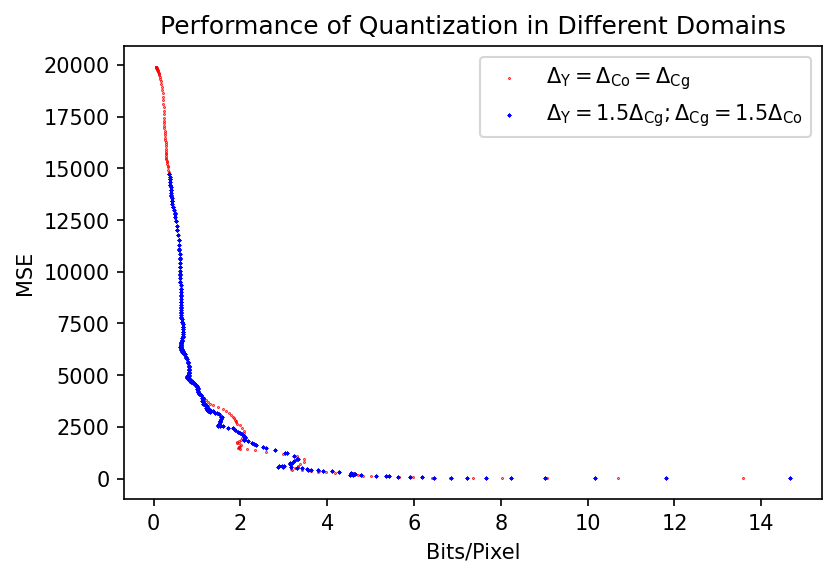

In [55]:
pylab.figure(dpi=150)
pylab.scatter(*zip(*YCoCg_points), c='r', marker=".", s=0.5,
           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$')
pylab.scatter(*zip(*YCoCg_gains_points), c='b', marker="x", s=1,
           label='$\Delta_{\mathrm{Y}}=' + "{:3.1f}".format(relative_Y_gain) + '\Delta_{\mathrm{Cg}}' +
           ';\Delta_{\mathrm{Cg}}=' + "{:3.1f}".format(relative_Cg_gain) + '\Delta_{\mathrm{Co}}$')
pylab.title("Performance of Quantization in Different Domains")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

### Comparing the three domains using the same quantization steps

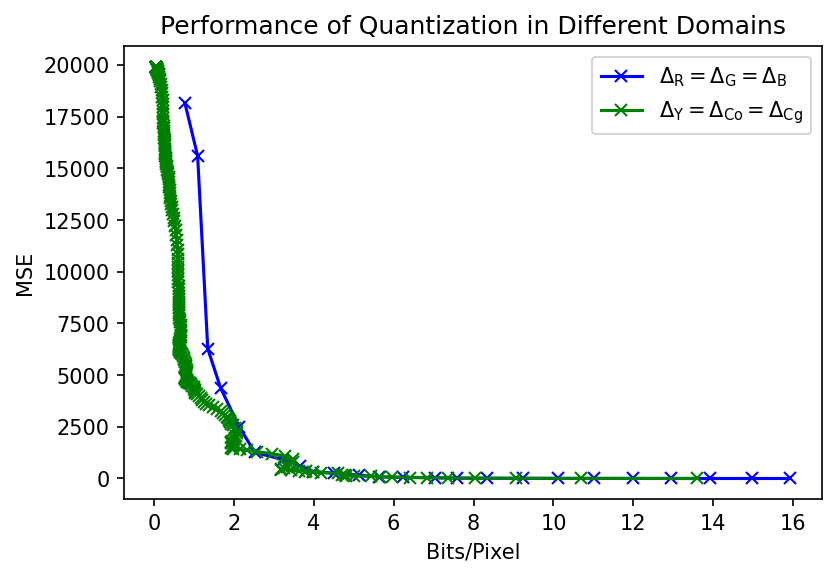

In [57]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RGB_points), c='b', marker="x",
           label='$\Delta_{\mathrm{R}}=\Delta_{\mathrm{G}}=\Delta_{\mathrm{B}}$')
#pylab.plot(*zip(*YCrCb_points), c='r', marker="x",
#           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$')
#pylab.plot(*zip(*YYCrCb_gains_points), c='m', marker="x",
#           label='$\Delta_{\mathrm{Y}}=' + "{:3.1f}".format(Y_gain) + '\Delta_{\mathrm{Cr}}' +
#           ';\Delta_{\mathrm{Cb}}=' + "{:3.1f}".format(Cb_gain) + '\Delta_{\mathrm{Cr}}$')
pylab.plot(*zip(*YCoCg_points), c='g', marker="x",
           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$')
pylab.title("Performance of Quantization in Different Domains")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

In [59]:
Cr_gain = 1.0 # 2.4754
Cb_gain = 3.25832/2.4754
Y_gain = 3/2.4754
def YYCrCb_RD_curve_with_gains(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        YYCrCb_frame = YCrCb.from_RGB(RGB_frame.astype(np.uint8))
        dequantized_YYCrCb_frame = np.empty_like(YYCrCb_frame)
        k = np.empty_like(YYCrCb_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YYCrCb_frame[:,:,0] = q_deq(YYCrCb_frame[:,:,0], (1<<q_step)/Y_gain)
        k[:,:,1], dequantized_YYCrCb_frame[:,:,1] = q_deq(YYCrCb_frame[:,:,1], (1<<q_step)/Cr_gain)
        k[:,:,2], dequantized_YYCrCb_frame[:,:,2] = q_deq(YYCrCb_frame[:,:,2], (1<<q_step)/Cb_gain)
        rate = bits_per_RGB_pixel(k)
        dequantized_YYCrCb_frame = dequantized_YYCrCb_frame.astype(np.uint8)
        dequantized_RGB_frame = YCrCb.to_RGB(dequantized_YYCrCb_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} BPS, distortion={_distortion:>6.1f}")
    return RD_points

YYCrCb_gains_points = YYCrCb_RD_curve_with_gains(img)

image_3.write: /tmp/img000.png (512, 512, 3) uint8 466206 
q_step=  1, rate=14.22747802734375 BPS, distortion=   3.3
image_3.write: /tmp/img000.png (512, 512, 3) uint8 370754 
q_step=  2, rate=11.31451416015625 BPS, distortion=   7.2
image_3.write: /tmp/img000.png (512, 512, 3) uint8 281121 
q_step=  4, rate=8.579132080078125 BPS, distortion=  20.0
image_3.write: /tmp/img000.png (512, 512, 3) uint8 213458 
q_step=  8, rate=6.51422119140625 BPS, distortion=  70.1
image_3.write: /tmp/img000.png (512, 512, 3) uint8 153290 
q_step= 16, rate=4.67803955078125 BPS, distortion= 263.4
image_3.write: /tmp/img000.png (512, 512, 3) uint8 100209 
q_step= 32, rate=3.058135986328125 BPS, distortion=1158.7
image_3.write: /tmp/img000.png (512, 512, 3) uint8 60681 
q_step= 64, rate=1.851837158203125 BPS, distortion=4170.9
image_3.write: /tmp/img000.png (512, 512, 3) uint8 32728 
q_step=128, rate=0.998779296875 BPS, distortion=6766.4


Conclusions:
1. In general, quantization is more effective in the transformed domain considering the RD plane.
2. $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ is slightly better than $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$, at low bit-rates, and viceversa.
3. At low bit-rates, tt's better to quantize YCoCb than to quantize YCrCb. 

## Is $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ the best quantization in YCrCb?
No, $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$ is better than $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ at high bit-rates.

## Is $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ optimal at low bit-rates quantizing YCrCb?

In [62]:
N=5
def only_Y_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCrCb_frame = YCrCb.from_RGB(RGB_frame.astype(np.uint8))
        dequantized_YCrCb_frame = np.empty_like(YCrCb_frame)
        k = np.empty_like(YCrCb_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YCrCb_frame[:,:,0] = q_deq(YCrCb_frame[:,:,0], 1<<q_step)
        k[:,:,1], dequantized_YCrCb_frame[:,:,1] = q_deq(YCrCb_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCrCb_frame[:,:,2] = q_deq(YCrCb_frame[:,:,2], 1<<N)
        rate = bits_per_RGB_pixel(k)
        dequantized_YCrCb_frame = dequantized_YCrCb_frame.astype(np.uint8)
        assert dequantized_YCrCb_frame.all() >= 0
        dequantized_RGB_frame = YCrCb.to_RGB(dequantized_YCrCb_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
    return RD_points

def only_Cb_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCrCb_frame = YCrCb.from_RGB(RGB_frame.astype(np.uint8))
        dequantized_YCrCb_frame = np.empty_like(YCrCb_frame)
        k = np.empty_like(YCrCb_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YCrCb_frame[:,:,0] = q_deq(YCrCb_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_YCrCb_frame[:,:,1] = q_deq(YCrCb_frame[:,:,1], 1<<q_step)
        k[:,:,2], dequantized_YCrCb_frame[:,:,2] = q_deq(YCrCb_frame[:,:,2], 1<<N)
        rate = bits_per_RGB_pixel(k)
        assert dequantized_YCrCb_frame.all() >= 0
        dequantized_YCrCb_frame = dequantized_YCrCb_frame.astype(np.uint8)
        dequantized_RGB_frame = YCrCb.to_RGB(dequantized_YCrCb_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
    return RD_points

def only_Cr_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCrCb_frame = YCrCb.from_RGB(RGB_frame.astype(np.uint8))
        dequantized_YCrCb_frame = np.empty_like(YCrCb_frame)
        k = np.empty_like(YCrCb_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YCrCb_frame[:,:,0] = q_deq(YCrCb_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_YCrCb_frame[:,:,1] = q_deq(YCrCb_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCrCb_frame[:,:,2] = q_deq(YCrCb_frame[:,:,2], 1<<q_step)
        rate = bits_per_RGB_pixel(k)
        dequantized_YCrCb_frame = dequantized_YCrCb_frame.astype(np.uint8)
        assert dequantized_YCrCb_frame.all() >= 0
        dequantized_RGB_frame = YCrCb.to_RGB(dequantized_YCrCb_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
    return RD_points

only_Y_points = only_Y_RD_curve(img)
only_Cb_points = only_Cb_RD_curve(img)
only_Cr_points = only_Cr_RD_curve(img)

0 image_3.write: /tmp/img000.png (512, 512, 3) uint8 278224 
1 image_3.write: /tmp/img000.png (512, 512, 3) uint8 238432 
2 image_3.write: /tmp/img000.png (512, 512, 3) uint8 195066 
3 image_3.write: /tmp/img000.png (512, 512, 3) uint8 152207 
4 image_3.write: /tmp/img000.png (512, 512, 3) uint8 115689 
5 image_3.write: /tmp/img000.png (512, 512, 3) uint8 85355 
6 image_3.write: /tmp/img000.png (512, 512, 3) uint8 68199 
7 image_3.write: /tmp/img000.png (512, 512, 3) uint8 58097 
0 image_3.write: /tmp/img000.png (512, 512, 3) uint8 247277 
1 image_3.write: /tmp/img000.png (512, 512, 3) uint8 204260 
2 image_3.write: /tmp/img000.png (512, 512, 3) uint8 164630 
3 image_3.write: /tmp/img000.png (512, 512, 3) uint8 125310 
4 image_3.write: /tmp/img000.png (512, 512, 3) uint8 98681 
5 image_3.write: /tmp/img000.png (512, 512, 3) uint8 85355 
6 image_3.write: /tmp/img000.png (512, 512, 3) uint8 71014 
7 image_3.write: /tmp/img000.png (512, 512, 3) uint8 69762 
0 image_3.write: /tmp/img000.pn

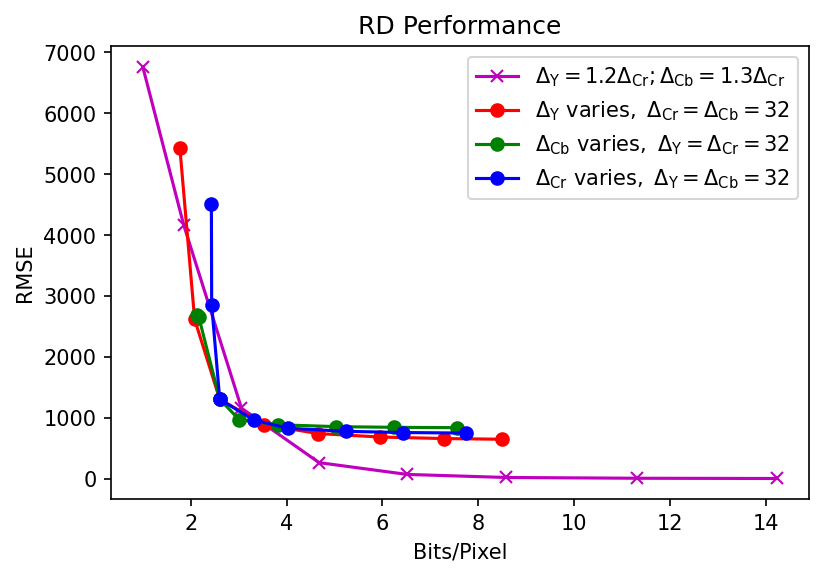

In [63]:
pylab.figure(dpi=150)
pylab.plot(*zip(*YYCrCb_gains_points), c='m', marker="x",
           label='$\Delta_{\mathrm{Y}}=' + "{:3.1f}".format(Y_gain) + '\Delta_{\mathrm{Cr}}' +
           ';\Delta_{\mathrm{Cb}}=' + "{:3.1f}".format(Cb_gain) + '\Delta_{\mathrm{Cr}}$')
pylab.plot(*zip(*only_Y_points), c='r', marker="o",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_Cb_points), c='g', marker="o",
           label='$\Delta_{\mathrm{Cb}}~\mathrm{varies},~\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_Cr_points), c='b', marker="o",
           label='$\Delta_{\mathrm{Cr}}~\mathrm{varies},~\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<N))              
pylab.title("RD Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

No, there are combinations of $\Delta_{\mathrm{Y}}$, $\Delta_{\mathrm{Cr}}$, and $\Delta_{\mathrm{Cb}}$ better than $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ at low bit-rates.

## Is $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$ optimal quantizing YCoCb?

In [64]:
N=4
def only_Y_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCoCg_frame = YCoCg.from_RGB(RGB_frame.astype(np.int16))
        dequantized_YCoCg_frame = np.empty_like(YCoCg_frame)
        k = np.empty_like(YCoCg_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YCoCg_frame[:,:,0] = q_deq(YCoCg_frame[:,:,0], 1<<q_step)
        k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], 1<<N)
        #k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], 1<<q_step)
        #k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], 1<<q_step)
        rate = bits_per_RGB_pixel(k)
        dequantized_RGB_frame = YCoCg.to_RGB(dequantized_YCoCg_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
    return RD_points

def only_Co_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCoCg_frame = YCoCg.from_RGB(RGB_frame.astype(np.int16))
        dequantized_YCoCg_frame = np.empty_like(YCoCg_frame)
        k = np.empty_like(YCoCg_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YCoCg_frame[:,:,0] = q_deq(YCoCg_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], 1<<q_step)
        k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], 1<<N)
        rate = bits_per_RGB_pixel(k)
        dequantized_RGB_frame = YCoCg.to_RGB(dequantized_YCoCg_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
    return RD_points

def only_Cg_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCoCg_frame = YCoCg.from_RGB(RGB_frame.astype(np.int16))
        dequantized_YCoCg_frame = np.empty_like(YCoCg_frame)
        k = np.empty_like(YCoCg_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YCoCg_frame[:,:,0] = q_deq(YCoCg_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], 1<<q_step)
        rate = bits_per_RGB_pixel(k)
        dequantized_RGB_frame = YCoCg.to_RGB(dequantized_YCoCg_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
    return RD_points

only_Y_points = only_Y_RD_curve(img)
only_Co_points = only_Co_RD_curve(img)
only_Cg_points = only_Cg_RD_curve(img)

0 image_3.write: /tmp/img000.png (512, 512, 3) uint8 297459 
1 image_3.write: /tmp/img000.png (512, 512, 3) uint8 253598 
2 image_3.write: /tmp/img000.png (512, 512, 3) uint8 211582 
3 image_3.write: /tmp/img000.png (512, 512, 3) uint8 171371 
4 image_3.write: /tmp/img000.png (512, 512, 3) uint8 137080 
5 image_3.write: /tmp/img000.png (512, 512, 3) uint8 114103 
6 image_3.write: /tmp/img000.png (512, 512, 3) uint8 104981 
7 image_3.write: /tmp/img000.png (512, 512, 3) uint8 95884 
0 image_3.write: /tmp/img000.png (512, 512, 3) uint8 284407 
1 image_3.write: /tmp/img000.png (512, 512, 3) uint8 239737 
2 image_3.write: /tmp/img000.png (512, 512, 3) uint8 199541 
3 image_3.write: /tmp/img000.png (512, 512, 3) uint8 162756 
4 image_3.write: /tmp/img000.png (512, 512, 3) uint8 137080 
5 image_3.write: /tmp/img000.png (512, 512, 3) uint8 123260 
6 image_3.write: /tmp/img000.png (512, 512, 3) uint8 117445 
7 image_3.write: /tmp/img000.png (512, 512, 3) uint8 113514 
0 image_3.write: /tmp/img

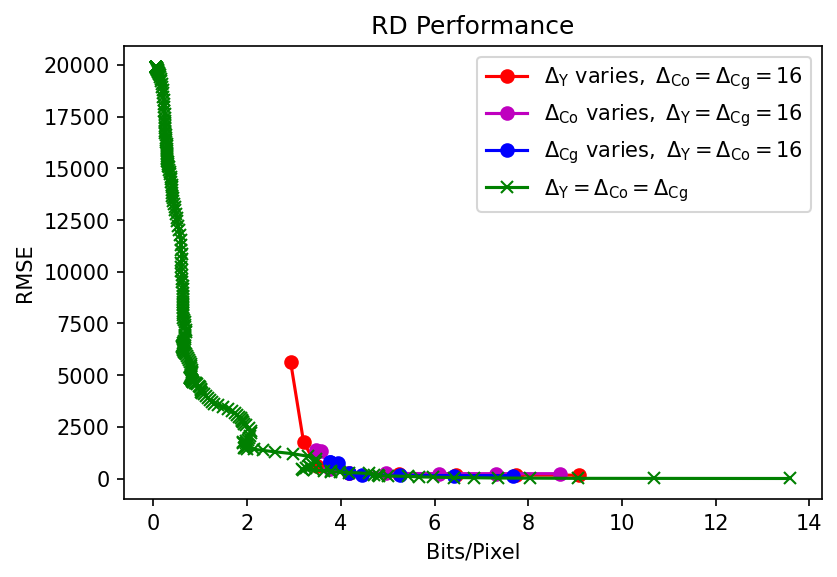

In [65]:
pylab.figure(dpi=150)
pylab.plot(*zip(*only_Y_points), c='r', marker="o",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_Co_points), c='m', marker="o",
           label='$\Delta_{\mathrm{Co}}~\mathrm{varies},~\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cg}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_Cg_points), c='b', marker="o",
           label='$\Delta_{\mathrm{Cg}}~\mathrm{varies},~\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*YCoCg_points), c='g', marker="x",
           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$')
pylab.title("RD Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

At least, using the same experiment than before, $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$ seems to be near optimal quantizing YCoCb.

## Ignore the rest ...

## Some experiments showing the impact of the lack of orthogonality

In [ ]:
def _YCbCr_RD_curve(RGB_frame, N):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint8))
        dequantized_YCbCr_frame = np.empty_like(YCbCr_frame)
        k = np.empty_like(YCbCr_frame)
        k[:,:,0], dequantized_YCbCr_frame[:,:,0] = q_deq(YCbCr_frame[:,:,0], 1<<q_step)
        k[:,:,1], dequantized_YCbCr_frame[:,:,1] = q_deq(YCbCr_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCbCr_frame[:,:,2] = q_deq(YCbCr_frame[:,:,2], 1<<N)
        rate = bytes_per_color_frame(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint8)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

_YCbCr_points_8 = _YCbCr_RD_curve(frame, 8)
_YCbCr_points_7 = _YCbCr_RD_curve(frame, 7)
_YCbCr_points_6 = _YCbCr_RD_curve(frame, 6)
_YCbCr_points_5 = _YCbCr_RD_curve(frame, 5)
_YCbCr_points_4 = _YCbCr_RD_curve(frame, 4)
_YCbCr_points_3 = _YCbCr_RD_curve(frame, 3)

In [ ]:
1<<4

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*YCbCr_points), c='r', marker="x",
           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$')
pylab.plot(*zip(*_YCbCr_points_8), c='b', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<8))
pylab.plot(*zip(*_YCbCr_points_7), c='g', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<7))
pylab.plot(*zip(*_YCbCr_points_6), c='c', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<6))
pylab.plot(*zip(*_YCbCr_points_5), c='m', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<5))
pylab.plot(*zip(*_YCbCr_points_4), c='y', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<4))
pylab.plot(*zip(*_YCbCr_points_3), c='k', marker="o",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<3))
pylab.plot(*zip(*YCbCr_gains_points), c='m', marker="+",
           label='$\Delta_{\mathrm{Y}}=' + "{:3.1f}".format(Y_gain) + '\Delta_{\mathrm{Cr}}' +
           ';\Delta_{\mathrm{Cb}}=' + "{:3.1f}".format(Cb_gain) + '\Delta_{\mathrm{Cr}}$')
pylab.title("The lack of non-orthogonality in the YCrCb transform")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

From this experiment we conclude that:
1. The luma should not be "deleted" from the code-stream (see curve $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$).
2. There are better combinations than $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$ and $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}};\Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$.

### YCrCb

It's possible to find better combinations than $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}};\Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$.

Notice that, at least visually, it does not make sense to use $\Delta_{\mathrm{Y}}\ge 8$ because the reconstructed image will be very dark or even black. The same holds for YCoCg.

In [ ]:
ycc = RGB_to_YCbCr(frame.astype(np.uint8))
ycc[:,:,0] = 0
frame2 = YCbCr_to_RGB(ycc)
print(frame2.min(), frame2.max())
show_frame(frame2, "$\Delta_{\mathrm{Y}} \ge 8$" + " (YCbCr domain)")

### YCoCg

Notice that, at least visually, it does not make sense to use $\Delta_{\mathrm{Y}}\ge 8$ because the reconstructed image will be very dark or even black. The same holds for YCoCg.

In [ ]:
ycc = RGB_to_YCoCg(frame)
ycc[:,:,0]= 0
frame2 = YCoCg_to_RGB(ycc)
print(frame2.min(), frame2.max())
show_frame(frame2, "$\Delta_{\mathrm{Y}} \ge 8$" + " (YCoCg domain)")

In [ ]:
def YCbCr_RD_curve_only_Y(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint8))
        YCbCr_frame[:,:,1] = 0
        YCbCr_frame[:,:,2] = 0
        k, dequantized_YCbCr_frame = q_deq(YCbCr_frame, 1<<q_step)
        k[:,:,0] = 0
        rate = byte_rate(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint8)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

def YCbCr_RD_curve_only_Cb(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint8))
        YCbCr_frame[:,:,0] = 0
        YCbCr_frame[:,:,2] = 0
        k, dequantized_YCbCr_frame = q_deq(YCbCr_frame, 1<<q_step)
        rate = byte_rate(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint8)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

def YCbCr_RD_curve_only_Cr(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint8))
        YCbCr_frame[:,:,0] = 0
        YCbCr_frame[:,:,1] = 0
        k, dequantized_YCbCr_frame = q_deq(YCbCr_frame, 1<<q_step)
        rate = byte_rate(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint8)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

only_Y_curve = YCbCr_RD_curve_only_Y(frame)
only_Cb_curve = YCbCr_RD_curve_only_Cb(frame)
only_Cr_curve = YCbCr_RD_curve_only_Cr(frame)

In [ ]:
pylab.figure(dpi=150)
pylab.scatter(*zip(*only_Y_curve), s=2, c='r', marker="o", label='only Y')
pylab.plot(*zip(*only_Y_curve), c='r', marker="o")
pylab.scatter(*zip(*only_Cb_curve), s=2, c='g', marker="o", label='only Cb')
pylab.plot(*zip(*only_Cb_curve), c='g', marker="o")
pylab.scatter(*zip(*only_Cr_curve), s=2, c='b', marker="o", label='only Cr')
pylab.plot(*zip(*only_Cr_curve), c='b', marker="o")
pylab.title("R/D Performance")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

In [ ]:
def YCbCr_RD_curve_2(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint16))
        YCbCr_frame[:,:,1] //= 2
        YCbCr_frame[:,:,2] //= 2
        k, dequantized_YCbCr_frame = q_deq(YCbCr_frame, 1<<q_step)
        dequantized_YCbCr_frame[:,:,1] *= 2
        dequantized_YCbCr_frame[:,:,2] *= 2
        rate = byte_rate(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint16)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

YCbCr_quantization_2 = YCbCr_RD_curve_2(frame)

In [ ]:
pylab.figure(dpi=150)
pylab.scatter(*zip(*RGB_quantization), s=2, c='b', marker="o", label='RGB quantization')
pylab.plot(*zip(*RGB_quantization), c='b', marker="o")
pylab.scatter(*zip(*YCbCr_quantization), s=2, c='r', marker="o", label='YCbCr quantization')
pylab.plot(*zip(*YCbCr_quantization), c='r', marker="o")
pylab.scatter(*zip(*YCbCr_quantization_2), s=2, c='g', marker="o", label='YCbCr quantization 2')
pylab.plot(*zip(*YCbCr_quantization_2), c='g', marker="o")
pylab.title("R/D Only Quantization")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

In [ ]:
YCbCr_test_frame = np.array([255, 0, 0], dtype=np.int16).reshape((1,1,1))
print(YCbCr_to_RGB(YCbCr_test_frame))

In [ ]:
np.array([255, 0, 0], dtype=np.int16)

In [ ]:
YCbCr_test_frame = np.zeros_like(frame).astype(np.uint16)

In [ ]:
type(YCbCr_test_frame[0,0,0])

In [ ]:
YCbCr_test_frame[1,1,2] = 255

In [ ]:
RGB_test_frame = YCbCr_to_RGB(YCbCr_test_frame)

In [ ]:
print(average_energy(RGB_test_frame))

In [ ]:
show_frame(RGB_test_frame, "")